## Roots Classical Music Project

### RagaVerse


Importing libraries, loading metadata spreadsheet 

In [70]:
import os
import numpy as np
import pandas as pd
import librosa
import parselmouth
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Load CSV (column 'name' = filename, 'tonic' = musical note like 'A3')


file_path = "RagaVerseDatabase.xlsx"  # Your Excel file (download the spreadsheet we are using)

# Load all sheets
xls = pd.ExcelFile(file_path)

# Merge all sheets, adding a 'Thaat' column for each
merged_df = pd.concat(
    [xls.parse(sheet_name).assign(Thaat=sheet_name) for sheet_name in xls.sheet_names],
    ignore_index=True
)

# Save merged data back to the same file as a new sheet called 'Merged'
with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    merged_df.to_excel(writer, sheet_name='Merged', index=False)

# Load the merged sheet as a normal DataFrame
final_df = pd.read_excel(file_path, sheet_name='Merged')

# Optional: View the result
print(final_df.head(10))



              Raga Tonic                                       YouTube Link  \
0            Yaman    B3  https://www.youtube.com/watch?v=kXJxMbmzqWc&li...   
1           Hameer    B3  https://www.youtube.com/watch?v=fc_FVEkXOqA&li...   
2           Hameer    D3  https://www.youtube.com/watch?v=FtObMbpIJLQ&li...   
3           Hameer    D3  https://www.youtube.com/watch?v=BkQ6eB_c11w&li...   
4             Nand    B3  https://www.youtube.com/watch?v=nUljNh4DEW4&li...   
5             Nand    C4  https://www.youtube.com/watch?v=xgYQacGP-ZE&li...   
6            kedar   C#4  https://www.youtube.com/watch?v=lvc0dAa3E_Q&li...   
7     Shyam Kalyan    B3  https://www.youtube.com/watch?v=Dn95jiD-RZU&li...   
8     Shyam Kalyan   NaN  https://www.youtube.com/watch?v=yeyWeWti0y0&li...   
9  Alhaiya Bilawal    B3  https://www.youtube.com/watch?v=TYVC5GeQCvo&li...   

              Name       Artist name (initials) Start Time (s) End Time (s)  \
0         yaman_MB                  Manali Bose    

set sampling rate and any other global variables


In [71]:
sr = 48000

Loading audio file using librosa, and conversion to pitch contour at window length 10ms, using pyin algorithm

In [72]:
def audio_to_sine_wave(filepath, sr=16000, win_size=0.01):
    snd = parselmouth.Sound(filepath).resample(new_frequency=sr)
    pitch = snd.to_pitch(time_step=win_size)  # time_step = analysis hop size

    # Extract pitch values
    f0 = pitch.selected_array['frequency']  # In Hz
    
    # Generate sine wave based on f0
    duration = snd.get_total_duration()
    t = np.linspace(0, duration, len(f0))
    sine = np.sin(2 * np.pi * np.nan_to_num(f0) * t)

    return f0, sine, sr


hertz to cents conversion using tonic of the audio file

In [73]:
def hz_to_cents(f0, name):
    tonic_str = final_df.loc[final_df['Name'] == name, 'Tonic'].values
    if tonic_str.size > 0:
        tonic = librosa.note_to_hz(tonic_str[0])
    else:
        tonic = librosa.note_to_hz('B3')  # Default tonic if not found
    if tonic is None:
        # Use median non-zero value as tonic estimate
        tonic = np.median(f0[f0 > 0])
    cents = 1200 * np.log2(f0 / tonic)
    cents[f0 <= 0] = np.nan  # Ignore unvoiced
    return cents, tonic


plotting function for the pitch contour (x: time, y: cents)

In [74]:
def plot_pitch_contour(cents, sr, hop_length=sr/100):
    time = np.arange(len(cents)) * hop_length / sr
    plt.figure(figsize=(10, 3))
    plt.plot(time, cents, label='Pitch contour (cents)')
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch (cents)')
    plt.title('Pitch Contour')
    plt.grid(True)
    plt.show()


Pre-processing ends______________________________________________________________________________________________________________________________

Compute pitch class distributions

In [75]:
def compute_pitch_class_distribution(cents, bins=1200):
    # Wrap around 1200 cents (1 octave)
    pitch_classes = np.mod(cents, 1200)
    pitch_classes = pitch_classes[~np.isnan(pitch_classes)]
    hist, _ = np.histogram(pitch_classes, bins=bins, range=(0, 1200), density=True)
    return hist

# this funcction returns a 12 dim vector of pitch class distribution


Compute more features!!

In [76]:
# Compute additional features
# add your feature (should be a number or a set of numbers at the end of processing)


dimensionality reduction to n components (n=2) using pca or t-SNE and plotting

In [77]:
def plot_2d_embedding(features, labels=None, method='pca'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=5)
    else:
        raise ValueError("Choose 'pca' or 'tsne'")
    
    scaled = StandardScaler().fit_transform(features)
    embedding = reducer.fit_transform(scaled)
    
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels)
    plt.title(f'{method.upper()} Projection of Pitch Class Distributions')
    plt.show()


Add your feature

/var/folders/lc/598jm6692t38zzq_tcm91n240000gn/T/ipykernel_39634/874947043.py:10: RuntimeWarning: divide by zero encountered in log2
  cents = 1200 * np.log2(f0 / tonic)
/Users/yashbhake/Desktop/MIR/RagaVerse/ragaverse_venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/yashbhake/Desktop/MIR/RagaVerse/ragaverse_venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/yashbhake/Desktop/MIR/RagaVerse/ragaverse_venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/yashbhake/Desktop/MIR/RagaVerse/ragaverse_venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/yashbhake/Desktop/MIR/RagaVerse/ragaverse_venv/lib/pytho

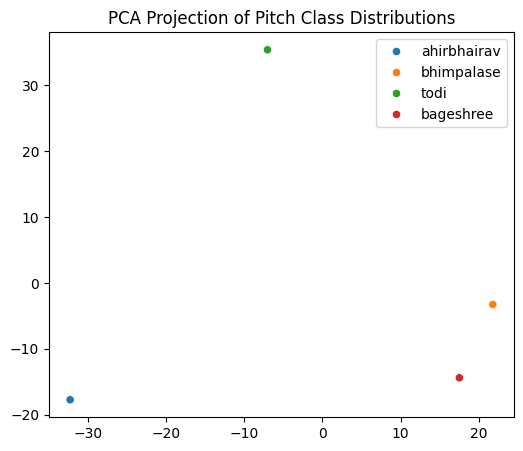

In [78]:
audio_dir = "tools/separated/vocals"
features = []
labels = []

for filename in os.listdir(audio_dir):
    if filename.endswith(".wav"):
        path = os.path.join(audio_dir, filename)
        f0, sine, sr = audio_to_sine_wave(path)
        cents, tonic = hz_to_cents(f0, name=filename.split('.')[0])  # Use filename as name
        hist = compute_pitch_class_distribution(cents)
        features.append(hist)
        #append your new feature in features, or try out the features ablatively.
        labels.append(filename.split('_')[0])  # or use raga name

plot_2d_embedding(features, labels, method='pca')
